In [20]:
#imports
import pandas as pd
import matplotlib.pyplot as plt # for visualizations

#ML Packages
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#pre-processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

#metrics and reporting
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [2]:
#read in the raw csv file
df = pd.read_csv("../data/cleaned_data.csv", encoding= 'utf-8')
df.head(3)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,InsideOutside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Premise
0,9/5/20,1:30:00,6G,800 PONTIAC AVE,LARCENY,Inside,None,913.0,SOUTHERN,BROOKLYN,-76.598564,39.233880,ROW/TOWNHOUSE-OCC
1,9/5/20,19:57:00,4E,4900 GUNTHER AVE,COMMON ASSAULT,Inside,None,443.0,NORTHEAST,FRANKFORD,-76.549157,39.327377,ROW/TOWNHOUSE-OCC
2,9/5/20,2:10:00,4D,600 MELVILLE AVE,AGG. ASSAULT,Inside,HANDS,515.0,NORTHERN,WAVERLY,-76.607271,39.331543,ROW/TOWNHOUSE-OCC


In [3]:
df['Weapon'].value_counts() #get the counts for each weapon

None       246173
FIREARM     32824
OTHER       18820
KNIFE       10865
HANDS        4209
Name: Weapon, dtype: int64

In [42]:
#take the highest count and divide it by the sum to get the dummy accuracy if we predicted only None
246173 / (246173 + 32824 + 18820 + 10865 + 4209)

0.7867691943839867

In [5]:
#first attempt at transforming the data to be numeric.  Used labelBinarizer, but the column headers were integers
#so found a more intuitive way to do it below.
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(df['Description'])
transformed = jobs_encoder.transform(df['Description'])
ohe_df = pd.DataFrame(transformed)
data = pd.concat([df, ohe_df], axis=1).drop(['Description'], axis=1)

jobs_encoder.fit(df['InsideOutside'])
transformed = jobs_encoder.transform(df['InsideOutside'])
transformed_df = pd.DataFrame(transformed)
data = pd.concat([data, transformed_df], axis=1).drop(['InsideOutside'], axis=1)
data.head(3)

jobs_encoder.fit(df['Premise'])
transformed = jobs_encoder.transform(df['Premise'])
transformed_premise_df = pd.DataFrame(transformed)
data = pd.concat([data, transformed_premise_df], axis=1).drop(['Premise'], axis=1)
data.head(3)

,CrimeDate,CrimeTime,CrimeCode,Location,Weapon,Post,District,Neighborhood,Longitude,Latitude,...,115,116,117,118,119,120,121,122,123,124
0,9/5/20,1:30:00,6G,800 PONTIAC AVE,None,913.0,SOUTHERN,BROOKLYN,-76.598564,39.233880,...,0,0,0,0,0,0,0,0,0,0
1,9/5/20,19:57:00,4E,4900 GUNTHER AVE,None,443.0,NORTHEAST,FRANKFORD,-76.549157,39.327377,...,0,0,0,0,0,0,0,0,0,0
2,9/5/20,2:10:00,4D,600 MELVILLE AVE,HANDS,515.0,NORTHERN,WAVERLY,-76.607271,39.331543,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#here we create dummy features for each of the categorical columns we see as valuable for our model
#the pandas get_dummies function returns a dataframe with the dummies used for that column
#then we concat that dataframe onto the original and drop the original column
dummies = pd.get_dummies(df['InsideOutside'])
dummyDF = pd.concat([df, dummies], axis=1).drop(['InsideOutside'], axis=1)

dummies = pd.get_dummies(df['Description'])
dummyDF = pd.concat([dummyDF, dummies], axis=1).drop(['Description'], axis=1) #add onto the dummies DF

dummies = pd.get_dummies(df['Premise'])
dummyDF = pd.concat([dummyDF, dummies], axis=1).drop(['Premise'], axis=1)
dummyDF = dummyDF.drop(['UNKNOWN'], axis=1) #unknown column is not going to tell us anything - drop it
dummyDF.head(2)

,CrimeDate,CrimeTime,CrimeCode,Location,Weapon,Post,District,Neighborhood,Longitude,Latitude,...,TRUCKING & TRANSFER,UTILITIES-BG&E-C&P,VACANT BUILDING,VACANT DWELLING,VACANT LOT/WOODS,VEHICLE,WAREHOUSE,WHOLESALE/DISC. STOR,YARD,YARD/BUSINESS
0,9/5/20,1:30:00,6G,800 PONTIAC AVE,None,913.0,SOUTHERN,BROOKLYN,-76.598564,39.233880,...,0,0,0,0,0,0,0,0,0,0
1,9/5/20,19:57:00,4E,4900 GUNTHER AVE,None,443.0,NORTHEAST,FRANKFORD,-76.549157,39.327377,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Create columns for the hour and month, since they seem to have the highest impact
df["CrimeDate"] = df["CrimeDate"].astype("datetime64")
df["CrimeTime"] = df["CrimeTime"].astype("datetime64")

dummyDF['CrimeMonth'] = pd.DatetimeIndex(df['CrimeDate']).month
dummyDF['CrimeHour'] = pd.DatetimeIndex(df['CrimeTime']).hour
dummyDF.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Weapon,Post,District,Neighborhood,Longitude,Latitude,...,VACANT BUILDING,VACANT DWELLING,VACANT LOT/WOODS,VEHICLE,WAREHOUSE,WHOLESALE/DISC. STOR,YARD,YARD/BUSINESS,CrimeMonth,CrimeHour
0,9/5/20,1:30:00,6G,800 PONTIAC AVE,None,913.0,SOUTHERN,BROOKLYN,-76.598564,39.233880,...,0,0,0,0,0,0,0,0,9,1
1,9/5/20,19:57:00,4E,4900 GUNTHER AVE,None,443.0,NORTHEAST,FRANKFORD,-76.549157,39.327377,...,0,0,0,0,0,0,0,0,9,19
2,9/5/20,2:10:00,4D,600 MELVILLE AVE,HANDS,515.0,NORTHERN,WAVERLY,-76.607271,39.331543,...,0,0,0,0,0,0,0,0,9,2
3,9/5/20,1:00:00,7A,AV & REISTERSTOWN RD,None,611.0,NORTHWEST,LIBERTY SQUARE,-76.655664,39.322638,...,0,0,0,0,0,0,0,0,9,1
4,9/5/20,8:10:00,4C,1900 W FAIRMOUNT AVE,OTHER,714.0,WESTERN,PENROSE/FAYETTE STREET OUTREACH,-76.647524,39.288932,...,0,0,0,0,0,0,0,0,9,8


In [8]:
#Function to Draw tree taken from python utils file

def draw_tree(estimator, figsize =(15, 5), feature_names = ["Hits", "Years"]):
    """
    Takes a decision  tree estimator and plots it's tree structure
    :param estimator: A sklearn decision tree estimator. Should be fitted.
    :param figsize: tuple. (int, int).
    :param feature_names:
    :return: It returns a plot. The image is not saved.
    """
    fig = plt.figure(figsize= figsize)
    _ = tree.plot_tree(estimator,
                       feature_names= feature_names,
                       filled=True)

[[ 3614     0     0  1234  1717]
 [    0     0     0     0   842]
 [  500     0     0   104  1569]
 [ 1757     0     0 47478     0]
 [  425     0     0   528  2811]]


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     FIREARM       0.57      0.55      0.56      6565
       HANDS       0.00      0.00      0.00       842
       KNIFE       0.00      0.00      0.00      2173
        None       0.96      0.96      0.96     49235
       OTHER       0.41      0.75      0.53      3764

    accuracy                           0.86     62579
   macro avg       0.39      0.45      0.41     62579
weighted avg       0.84      0.86      0.85     62579



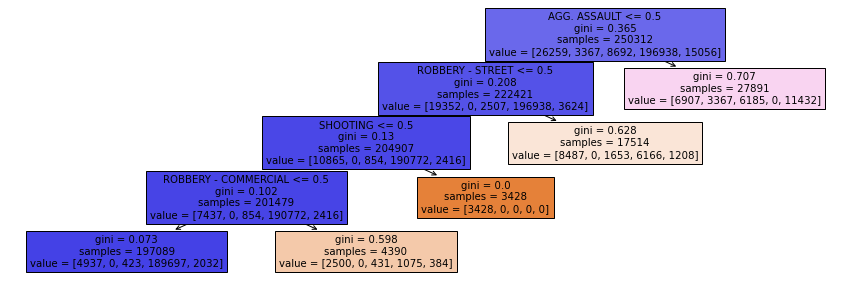

In [43]:
## here let's apply sklearn DecisionTreeClassifier

#drop the columns that are not predictors
X = dummyDF.drop(['Weapon', 'CrimeDate', 'CrimeTime', 'Location', 'CrimeCode', 'Post', 'District', 'Neighborhood', 'Longitude', "Latitude"], axis=1)
#print(X.head())
y = dummyDF['Weapon'] #set the goal to be the classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 1, stratify = y) #split the data

classifier = DecisionTreeClassifier(max_leaf_nodes= 5) #create the classifier and fit it
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)  #predict using the test data for metrics

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

draw_tree(classifier,feature_names= X_train.columns)

In [129]:
#lets try a bunch of different parameters to see what gives the highest accuracy
grid = {'max_leaf_nodes': [5, 10, 15, 25, 100], 'ccp_alpha': [0, 0.01, 0.1, 1, 10, 100], "min_impurity_split":[0,0.1,0.2,0.3,0.4,0.5]}
grid_search_cv = GridSearchCV(estimator = classifier, param_grid= grid, cv =5, return_train_score= True, verbose= 2)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.cv_results_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0, total=   2.1s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, total=   3.0s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0, total=   3.0s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0, total=   3.3s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.8s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3, total=   2.0s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.9s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3, total=   2.0s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0, total=   2.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0, total=   2.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0, total=   3.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0, total=   2.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0, total=   3.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0, total=   3.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2, total=   2.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2, total=   2.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.2, total=   2.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0, total=   2.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0, total=   3.7s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0, total=   3.3s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.6s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5 ......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.01, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0, total=   2.1s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0, total=   2.2s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0, total=   1.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2, total=   2.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2, total=   2.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.2, total=   3.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3, total=   2.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0, total=   3.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0, total=   2.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=0.1, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0, total=   1.7s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0, total=   1.7s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0, total=   1.7s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0, total=   1.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0 .............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0, total=   1.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2, total=   3.4s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.2, total=   4.2s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3, total=   6.0s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.1s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0, total=   2.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0, total=   2.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0, total=   2.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0, total=   2.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1, total= 1.7min
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.7s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.1, total=   1.6s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.0s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0, total=   2.8s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.5s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1, total=   3.7s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1, total=   8.0s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.5s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0, total=   4.2s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.1, total=   1.8s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.6s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.2, total=   1.5s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.3s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.9s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0, total=   2.8s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.0s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1, total=   5.0s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.1, total=   4.1s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2, total=   3.2s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2, total=   4.0s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2, total=   3.1s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.7s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.2, total=   3.1s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3, total=   2.3s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3, total=   2.0s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.5s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.7s
[CV] ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=1, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0, total=   2.5s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0, total=   2.8s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0 ............


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2, total=   2.7s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2, total=   3.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2, total=   3.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2, total=   2.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.2, total=   2.1s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0, total=   3.3s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0, total=   3.5s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0, total=   3.0s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0, total=   3.0s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2, total=   3.5s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2, total=   2.6s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.3s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0, total=   3.4s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2, total=   2.6s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2, total=   2.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3, total=   2.0s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.5s
[CV] ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0, total=   3.6s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0, total=   3.5s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0, total=   3.5s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0, total=   3.4s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.1, total=   3.0s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.7s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.3s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.3s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0, total=   3.6s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0, total=   3.5s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0, total=   3.7s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0, total=   4.2s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0, total=   3.7s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1, total=   3.0s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1, total=   3.1s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1, total=   3.8s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1, total=   4.9s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.9s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.4s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.5s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.5s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.9s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.9s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.4s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.5s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.4s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=10, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0, total=   2.6s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0, total=   2.7s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0 ...........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0, total=   2.3s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.9s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.9s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.1, total=   2.1s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.8s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.2, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.3, total=   1.5s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.4, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.5s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=5, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0, total=   3.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0, total=   3.0s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0, total=   2.9s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1, total=   3.4s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.1, total=   3.2s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=10, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0, total=   3.7s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1, total=   2.3s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1, total=   3.3s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.1, total=   3.0s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.4, total=   1.3s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=15, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0, total=   3.4s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0, total=   3.2s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0, total=   3.4s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0, total=   3.5s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0 ..........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0, total=   3.6s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.5s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.4s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.6s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1, total=   3.5s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.1, total=   2.6s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.0s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.1s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.2, total=   2.1s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.7s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.6s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.2s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.4, total=   1.5s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.5s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.2s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5 ........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=25, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0, total=   3.7s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0, total=   3.7s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0, total=   3.4s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0, total=   3.7s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0 .........


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0, total=   3.6s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.6s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1, total=   3.0s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1, total=   3.9s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.7s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.1, total=   2.7s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.2, total=   2.2s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.9s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.3, total=   1.8s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.5s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.4s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.4, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s
[CV] ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5 .......


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV]  ccp_alpha=100, max_leaf_nodes=100, min_impurity_split=0.5, total=   1.1s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 36.5min finished
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


{'mean_fit_time': array([ 1.99160643,  1.54992576,  1.37884998,  1.1750114 ,  0.80660386,
         0.80293283,  2.25440483,  1.68636279,  1.35051789,  1.14716892,
         0.81012115,  0.8395752 ,  2.53725367,  1.78353662,  1.47533021,
         1.18900547,  0.82176657,  0.82472029,  2.78558674,  2.02717962,
         1.59870925,  1.23653712,  0.79020801,  0.79973345,  2.96864052,
         2.05207944,  1.88042641,  1.69201279,  0.89523263,  0.93266287,
         1.8767261 ,  1.69595594,  1.3253746 ,  1.18180113,  0.87333083,
         0.87184072,  2.85275264,  1.83867455,  1.81571498,  1.43235636,
         0.82569222,  0.79009318,  2.44410901,  1.74948392,  1.7767776 ,
         1.36897697,  0.87522216,  0.96697145,  2.79624138,  2.12962761,
         1.48814588,  1.25755744,  0.82256026,  0.84806266,  2.85267181,
         2.01439872,  1.76647925,  1.37700601,  0.83904638,  1.02362084,
         2.08769021,  2.31233234,  2.23007894,  1.2965445 ,  0.85014062,
         0.85960631,  2.51309137, 

In [131]:
#see the results in a table, sorted by descending mean test score
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_test_score', ascending = False).T

,18,24,12,6,36,54,48,42,19,13,...,100,99,98,97,96,95,94,93,92,179
mean_fit_time,2.78559,2.96864,2.53725,2.2544,2.85275,2.85267,2.79624,2.44411,2.02718,1.78354,...,0.788799,1.10354,1.28177,21.5348,2.09646,0.756526,0.75543,2.04372,2.0918,0.947125
std_fit_time,0.194313,0.111201,0.162141,0.0720176,0.300759,0.175189,0.351599,0.060387,0.108294,0.148631,...,0.0133202,0.0192178,0.0199131,39.828,0.03469,0.00147556,0.000763066,1.94569,1.03749,0.008316
mean_score_time,0.129717,0.119482,0.114751,0.115043,0.141716,0.116698,0.135741,0.117191,0.122661,0.118104,...,0.113351,0.111885,0.112224,0.121029,0.109182,0.109105,0.108932,0.111167,0.240107,0.129047
std_score_time,0.00491865,0.00942634,0.00770703,0.00864103,0.0433458,0.00815542,0.0428568,0.00741932,0.00924151,0.0105404,...,0.00942592,0.00802831,0.00887661,0.00707819,0.00880092,0.00852042,0.00838496,0.00982994,0.239011,0.0102224
param_ccp_alpha,0,0,0,0,0.01,0.01,0.01,0.01,0,0,...,1,1,1,1,1,1,1,1,1,100
param_max_leaf_nodes,25,100,15,10,10,100,25,15,25,15,...,10,10,10,10,10,5,5,5,5,100
param_min_impurity_split,0,0,0,0,0,0,0,0,0.1,0.1,...,0.4,0.3,0.2,0.1,0,0.5,0.4,0.3,0.2,0.5
params,"{'ccp_alpha': 0, 'max_leaf_nodes': 25, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 100, 'min_i...","{'ccp_alpha': 0, 'max_leaf_nodes': 15, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 10, 'min_im...","{'ccp_alpha': 0.01, 'max_leaf_nodes': 10, 'min...","{'ccp_alpha': 0.01, 'max_leaf_nodes': 100, 'mi...","{'ccp_alpha': 0.01, 'max_leaf_nodes': 25, 'min...","{'ccp_alpha': 0.01, 'max_leaf_nodes': 15, 'min...","{'ccp_alpha': 0, 'max_leaf_nodes': 25, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 15, 'min_im...",...,"{'ccp_alpha': 1, 'max_leaf_nodes': 10, 'min_im...","{'ccp_alpha': 1, 'max_leaf_nodes': 10, 'min_im...","{'ccp_alpha': 1, 'max_leaf_nodes': 10, 'min_im...","{'ccp_alpha': 1, 'max_leaf_nodes': 10, 'min_im...","{'ccp_alpha': 1, 'max_leaf_nodes': 10, 'min_im...","{'ccp_alpha': 1, 'max_leaf_nodes': 5, 'min_imp...","{'ccp_alpha': 1, 'max_leaf_nodes': 5, 'min_imp...","{'ccp_alpha': 1, 'max_leaf_nodes': 5, 'min_imp...","{'ccp_alpha': 1, 'max_leaf_nodes': 5, 'min_imp...","{'ccp_alpha': 100, 'max_leaf_nodes': 100, 'min..."
split0_test_score,0.885704,0.885424,0.883786,0.882368,0.877994,0.877994,0.877994,0.877994,0.863872,0.863292,...,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769
split1_test_score,0.884446,0.885145,0.884585,0.882368,0.878313,0.878313,0.878313,0.878313,0.863891,0.864311,...,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769,0.786769


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[[ 4515     0     0   361  1707]
 [   10     0     0     0   851]
 [  568     0     0    85  1480]
 [ 1658     0     0 47595     0]
 [  489     0     0    88  3172]]


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     FIREARM       0.62      0.69      0.65      6583
       HANDS       0.00      0.00      0.00       861
       KNIFE       0.00      0.00      0.00      2133
        None       0.99      0.97      0.98     49253
       OTHER       0.44      0.85      0.58      3749

    accuracy                           0.88     62579
   macro avg       0.41      0.50      0.44     62579
weighted avg       0.87      0.88      0.87     62579



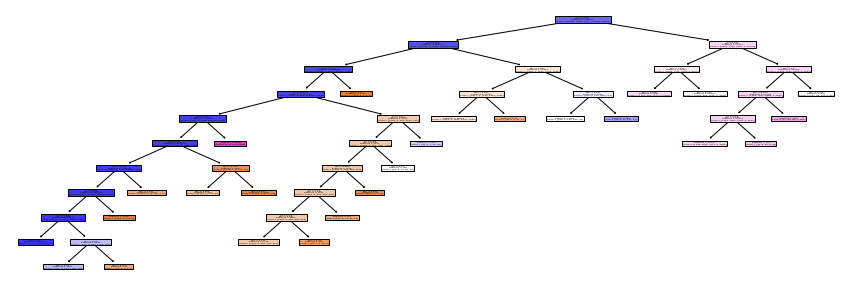

In [10]:
## here is the optimal decision tree

#drop the columns that are not predictors
X = data.drop(['Weapon', 'CrimeDate', 'CrimeTime', 'Location', 'CrimeCode', 'Post', 'District', 'Neighborhood', 'Longitude', "Latitude"], axis=1)
y = data['Weapon'] #set the goal to be the classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) #split the data

classifier = DecisionTreeClassifier(max_leaf_nodes= 25, min_impurity_split=0, ccp_alpha=0) #create the classifier and fit it
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)  #predict using the test data for metrics

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
draw_tree(classifier,feature_names= X_train.columns)

In [19]:
#Now lets try logistic regression
lr = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'saga', max_iter= 100)
cv_fivefold = cross_validate(estimator= lr, 
                             X = X,
                             y = y,
                             cv = 5,
                             return_train_score= True, 
                             return_estimator= True, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  49.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.6s remaining:    0.0s


[CV] ................................................. , total=  48.2s
[CV]  ................................................................
[CV] ................................................. , total=  51.7s
[CV]  ................................................................
[CV] ................................................. , total=  54.1s
[CV]  ................................................................
[CV] ................................................. , total=  45.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished


In [21]:
#results of the cross-validated logistic regression model
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

print('Logistic Regression 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

Logistic Regression 5-fold cv results (Accuracy) 0.883 =/- 0.005


In [ ]:
#Grid Search CV
#now lets try to find the best parameters for logistic regression
grid = {'C': [0.0000000000001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'none'], 'solver' : ['saga', 'lbfgs', 'sag', 'newton-cg'], "max_iter":[100,1000]}
grid_search_cv = GridSearchCV(estimator = lr, param_grid= grid, cv =5, return_train_score= True, verbose= 2)
grid_search_cv.fit(X_train_scaled, y_train)
grid_search_cv.cv_results_

In [ ]:
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_test_score', ascending = False).T

In [39]:
#Grid Search CV
#now lets try to find the best parameters for random forests
#this takes a pretty long time to run
#top commented out line takes longer to run but may give better results
#grid = {'n_estimators': [50,300,500,700], 'max_leaf_nodes': [5, 15, 25, 100], 'ccp_alpha': [0, 0.01, 0.1, 1, 10], 'criterion' : ['gini', 'entropy'], "min_impurity_split":[0,0.1,0.3,0.5], "n_jobs": [4]}
grid = {'n_estimators': [50,100], 'max_leaf_nodes': [15, 30, 50], 'ccp_alpha': [0, 0.1], "min_impurity_split":[0,0.1,0.5], "n_jobs": [4]}
grid_search_cv = GridSearchCV(estimator = rf, param_grid= grid, cv =5, return_train_score= True, verbose= 2)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.cv_results_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   9.1s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   6.3s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   5.5s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   5.2s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   5.5s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=100, n_jobs=4, total=  10.8s
[CV] ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=15, min_impurity_split=0, n_

[CV]  ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4, total=  11.5s
[CV] ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4, total=  11.4s
[CV] ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4, total=  11.4s
[CV] ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4, total=  12.6s
[CV] ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4, total=  11.4s
[CV] ccp_alpha=0, max_leaf_nodes=30, min_impurity_split=0.5, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=30

[CV]  ccp_alpha=0, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4, total=   2.7s
[CV] ccp_alpha=0, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4, total=   2.7s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   5.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   5.3s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   6.4s
[CV] ccp_alpha=0.1, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=15, mi

[CV]  ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=50, n_jobs=4, total=   5.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=50, n_jobs=4, total=   5.8s
[CV] ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=50, n_jobs=4, total=   6.1s
[CV] ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=50, n_jobs=4, total=   6.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4, total=  12.1s
[CV] ccp_alpha=0.1, max_leaf_nodes=30, min_impurity_split=0.1, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0.1, m

[CV]  ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=50, n_jobs=4, total=   1.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4, total=   2.5s
[CV] ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4, total=   3.0s
[CV] ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4, total=   2.9s
[CV] ccp_alpha=0.1, max_leaf_nodes=50, min_impurity_split=0.5, n_estimators=100, n_jobs=4 
[CV]  ccp_alpha=

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 29.0min finished
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

{'mean_fit_time': array([ 6.03874822, 12.7712923 ,  5.50176826,  9.33348103,  1.8937665 ,
         2.56459203,  6.35987501, 14.13671751,  6.1836453 , 11.26656866,
         1.77337055,  3.04625621,  7.40621848, 15.03561997,  7.21008515,
        13.12054844,  2.00817347,  2.49180279,  5.4176002 ,  9.48836536,
         5.05694494, 23.29126329, 44.66403828,  3.42644086,  6.78534741,
        11.21163526,  5.74725623, 11.01120758,  1.6437449 ,  2.46130934,
         7.11706295, 13.35289845,  6.65678873, 12.91566429,  1.67306528,
         2.53496799]),
 'std_fit_time': array([1.38146665e+00, 2.94470322e+00, 3.56773961e-01, 4.34156172e-01,
        1.15629580e-01, 6.47704550e-02, 3.24103091e-01, 1.68964322e+00,
        3.98114895e-01, 4.46842965e-01, 5.61530742e-02, 4.30346005e-01,
        6.76401379e-01, 1.50760656e+00, 6.71051351e-01, 8.80282169e-01,
        3.38658513e-02, 9.80509128e-02, 3.96943394e-01, 3.18254368e-01,
        5.18125014e-01, 2.88648177e+01, 8.57475901e+01, 9.11323656e-01,
 

In [40]:
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_test_score', ascending = False).T

,15,12,14,13,6,7,8,9,0,1,...,21,20,19,17,16,11,10,5,4,35
mean_fit_time,13.1205,7.40622,7.21009,15.0356,6.35988,14.1367,6.18365,11.2666,6.03875,12.7713,...,23.2913,5.05694,9.48837,2.4918,2.00817,3.04626,1.77337,2.56459,1.89377,2.53497
std_fit_time,0.880282,0.676401,0.671051,1.50761,0.324103,1.68964,0.398115,0.446843,1.38147,2.9447,...,28.8648,0.518125,0.318254,0.0980509,0.0338659,0.430346,0.0561531,0.0647705,0.11563,0.251652
mean_score_time,0.413629,0.306108,0.301105,0.408207,0.266448,0.431218,0.288873,0.389684,0.271853,0.472367,...,0.302973,0.201536,0.316229,0.305627,0.214795,0.352457,0.199553,0.304443,0.201165,0.30119
std_score_time,0.0088026,0.00678664,0.00313912,0.00613426,0.0422053,0.0946322,0.041855,0.0423445,0.0574921,0.214807,...,0.00672096,0.00391372,0.0131475,0.01105,0.00470672,0.0962965,0.00327495,0.0088548,0.0095808,0.00883032
param_ccp_alpha,0,0,0,0,0,0,0,0,0,0,...,0.1,0.1,0.1,0,0,0,0,0,0,0.1
param_max_leaf_nodes,50,50,50,50,30,30,30,30,15,15,...,15,15,15,50,50,30,30,15,15,50
param_min_impurity_split,0.1,0,0.1,0,0,0,0.1,0.1,0,0,...,0.1,0.1,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5
param_n_estimators,100,50,50,100,50,100,50,100,50,100,...,100,50,100,100,50,100,50,100,50,100
param_n_jobs,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
params,"{'ccp_alpha': 0, 'max_leaf_nodes': 50, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 50, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 50, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 50, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 30, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 30, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 30, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 30, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 15, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 15, 'min_im...",...,"{'ccp_alpha': 0.1, 'max_leaf_nodes': 15, 'min_...","{'ccp_alpha': 0.1, 'max_leaf_nodes': 15, 'min_...","{'ccp_alpha': 0.1, 'max_leaf_nodes': 15, 'min_...","{'ccp_alpha': 0, 'max_leaf_nodes': 50, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 50, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 30, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 30, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 15, 'min_im...","{'ccp_alpha': 0, 'max_leaf_nodes': 15, 'min_im...","{'ccp_alpha': 0.1, 'max_leaf_nodes': 50, 'min_..."


In [32]:
#create the optimal random forest
rf = RandomForestClassifier(max_leaf_nodes = 50, min_impurity_split = 0.1, n_estimators= 100, max_features='auto')

cv_fivefold = cross_validate(estimator= rf, 
                             X = X_train,
                             y = y_train,
                             cv = 5,
                             return_train_score= True, 
                             return_estimator= True, 
                             verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV] ................................................. , total= 1.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarni

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV] ................................................. , total= 1.7min
[CV]  ................................................................


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV] ................................................. , total= 1.6min
[CV]  ................................................................


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV] ................................................. , total= 1.7min
[CV]  ................................................................


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


[CV] ................................................. , total= 1.6min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.4min finished


In [41]:
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

print('Random Forest 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

Random Forest 5-fold cv results (Accuracy) 0.866 =/- 0.001


In [ ]:
#now lets try KNN
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#drop the columns that are not predictors
X = data.drop(['Weapon', 'CrimeDate', 'CrimeTime', 'Location', 'CrimeCode', 'Post', 'District', 'Neighborhood', 'Longitude', "Latitude"], axis=1)
y = data['Weapon'] #set the goal to be the classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) #split the data

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#########################
# KNN takes forever to run - there are too many columns/dimensions for it to be fast

#can test again with cross-validation here:
#depth = []
#for i in range(3,11,2):
#    knn = KNeighborsClassifier(n_neighbors=i)
    # Perform 10-fold cross validation 
#    scores = cross_val_score(estimator=knn, X=X, y=y, cv=10, n_jobs=4)
#    depth.append((i,scores.mean()))
#for elements in depth:
#    print("Depth: " + str(elements[0]) + " with accuracy of: " + str(elements[1]))
